In [1]:
from firedrake import *
import math
import time as tm

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


The modelled data $u$ is computed here by solving the forward acoustic wave equation:
\begin{align} 
    m_0 u_{tt}-\nabla^2 u &= f  \label{wave_eq},
\end{align}
$m_0(\mathbf{x}) = 1/(\rho v_p^2)$, where $\rho$ is the density, $v_p$ is $P$-wave velocity which is assumed to be piecewise--constant. The state variable $u = u (m_0, \mathbf{x},t)$ is defined here in the coordinate space $\mathbf{x} \in \Omega \subset \mathbb{R}^2$, and is time dependent, where $t\in [t_0, t_n]\subset \mathbb{R}$. The non--homogeneous term $f = f(\mathbf{x}, t)$ is given by a Ricker 
source, which reads: 
\begin{equation}
    f(\mathbf{x}, t)= \left(1-2\pi^{2}f_{0}^{2}\left(t-\displaystyle\frac{1}{f_{0}} \right)^{2}\right)
    \exp\left[\pi^{2}f_{0}^{2}\left(t-\displaystyle\frac{1}{f_{0}} \right)^{2}\right]
    \delta\left(\mathbf{x}-\mathbf{x}_0\right),
    \label{ricker}
\end{equation}

Defining the external forcing f of the wave equation...

In [2]:
def ricker_wavelet(t, freq, amp=1.0, delay=1.5):
    """Creates a Ricker source function with a
    delay in term of multiples of the distance
    between the minimums.
    """
    t = t - delay * math.sqrt(6.0) / (math.pi * freq)
    return (
        amp
        * (1.0 - (1.0 / 2.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t)
        * math.exp(
            (-1.0 / 4.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t
        )
    )

def delta_expr(x0, z, x, sigma_x=500.0):
    sigma_x = Constant(sigma_x)
    return exp(-sigma_x * ((z - x0[0]) ** 2 + (x - x0[1]) ** 2))

def full_ricker_wavelet(dt, tf, freq, amp=1.0, cutoff=None):
    """Compute the Ricker wavelet optionally applying low-pass filtering
    using cutoff frequency in Hertz.
    """
    nt = int(tf / dt)  # number of timesteps
    time = 0.0
    full_wavelet = np.zeros((nt,))
    for t in range(nt):
        full_wavelet[t] = ricker_wavelet(time, freq, amp)
        time += dt
    return full_wavelet

def external_forcing(RW, mesh, pos, V):

    z, x = SpatialCoordinate(mesh)

    source = Constant(pos) 
    delta  = Interpolator(delta_expr(source, z, x), V)

    excitation = Function(delta.interpolate())

    ricker = Constant(0)
    f = excitation * ricker

    return f, ricker

Setting the mesh, source and receivers positions.

In [3]:
mesh = RectangleMesh(100, 100, 1.0, 1.0)
source_pos = [0.5, 0.1]

rec_num = 100 
δs = np.linspace(0.1, 0.9, rec_num)
X, Y = np.meshgrid(δs,0.1)
xs = np.vstack((X.flatten(), Y.flatten())).T
point_cloud = VertexOnlyMesh(mesh, xs)
P = FunctionSpace(point_cloud, "DG", 0)

/home/daiane/firedrake/src/firedrake/firedrake/parloops.py:129: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


Inserting de velocity model parameter 

In [4]:
V = FunctionSpace(mesh, 'Lagrange', 1)
z, x = SpatialCoordinate(mesh)
vp = Function(V).interpolate(1.0 + 0.0 * x)
# File("velocity.pvd").write(vp)


In [5]:
tf = 0.5
dt = 0.001
nt = int(tf / dt)  # number of timesteps

freq = 5


In [6]:
# ct = 0


def waveSolver(interpolation=False):
    p = Function(V, name="p")
    phi = Function(V, name="phi")

    u = TrialFunction(V)
    v = TestFunction(V)

    RW = full_ricker_wavelet(dt,tf, freq)
    f, ricker = external_forcing(RW, mesh, source_pos, V)
    usol_recv = []
    for IT in range(nt):
        ricker.assign(RW[IT])
        phi -= dt / 2 * p
        solve(u * v * dx == v * p * dx + dt * vp * vp * inner(grad(v), grad(phi)) * dx + dt*vp*vp*f * v * dx,
              p, solver_parameters={'ksp_type': 'cg',
                                            'pc_type': 'sor',
                                            'pc_sor_symmetric': True})

        phi -= dt / 2 * p

        if interpolation:
            rec = interpolate(phi,P)
            usol_recv.append(rec.dat.data)
    if interpolation:
        return usol_recv


In [7]:
start_nointerpolate = tm.time()
waveSolver(interpolation=False)
end_nointerpolate   = tm.time()

start_interpolate = tm.time()
receiver_data = waveSolver(interpolation=True)
end_interpolate = tm.time()

time_nointerpolate = end_nointerpolate-start_nointerpolate
time_interpolate = end_interpolate-start_interpolate

print("Time not using interpolation: ", time_nointerpolate)
print("Time using interpolation: ", time_interpolate)

Time not using interpolation:  11.209734678268433
Time using interpolation:  34.52960777282715


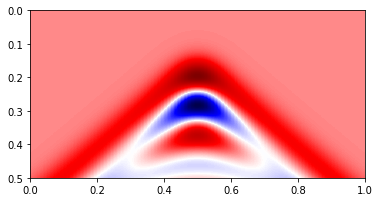

In [8]:
import matplotlib.pyplot      as plot


extent = [0,1,0.5,0]
    
plot.imshow(receiver_data, cmap="seismic", aspect=1, extent=extent)

plot.show()